<a href="https://colab.research.google.com/github/romanAVJ/Ido_proyectos/blob/master/nn_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get .py files and data from GitHub Repo

First clone the entire repository to local file and then start 

In [ ]:
# Clone the entire repo.
!git clone -l -s https://github.com/romanAVJ/Optimal_Bets_PremierLeague.git cloned-repo

# move to folder "cloned repo"
%cd cloned-repo


fatal: destination path 'cloned-repo' already exists and is not an empty directory.
/content/cloned-repo


In [ ]:
# look that we are in the right place
! ls 

## Import libraries and .py files

In [ ]:
# manually install dependencies of files
# adjustText
!pip install adjustText 

# uninstall scikit-learn (old verison) and install new version (>= 0.24)
!pip uninstall scikit-learn -y
!pip install -U scikit-learn
!pip uninstall sklearn -y
!pip install -U sklearn

# get libraries
import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow import keras
import os 
import random

from matplotlib import pyplot as plt
from adjustText import adjust_text

import Source.statistical_learning_model.nn_utils as nn_utils_ravj


Found existing installation: scikit-learn 0.24.2
Uninstalling scikit-learn-0.24.2:
  Successfully uninstalled scikit-learn-0.24.2
  Using cached scikit_learn-0.24.2-cp37-cp37m-manylinux2010_x86_64.whl (22.3 MB)
Found existing installation: sklearn 0.0
Uninstalling sklearn-0.0:
  Successfully uninstalled sklearn-0.0
  Using cached sklearn-0.0-py2.py3-none-any.whl


## Own functions 

Generate own functions to make easier and more neat the script

In [ ]:
# functions --------------------------------------------------------------------
# tidy dataframes
def get_dummies_results(df, var='y', prefix='y'):
    # working data frame
    df_work = df.copy()
    
    # one hot encode results
    y = pd.get_dummies(df_work[var], prefix=prefix, drop_first=False, dtype=int)
    names_y = y.columns.values
    
    # append to dataframe
    df_work[names_y] = y
    
    # reorder columns
    columns_names = df_work.columns.values
    columns_names = np.concatenate([names_y, columns_names[:-3]]) # number of y dummies'
    df_work = df_work[columns_names]
    
    # drop result
    df_work.drop(columns=var, inplace=True)
    
    return(df_work, list(names_y))

def split_trainvaltest(df, queries, objective_var='y', var='x'):    
    # working dataframe
    df_work = df.copy()    
    
    # get train, validation and test
    dbb = {}    
    for k,v in queries.items():
        df_subset = df_work.query(v)
        
        # save objective and covariables in dataframe
        dbb[k] = {'y': df_subset[objective_var], 'X': df_subset[var]}
        
    return(dbb)

def tidy_bdd(df, queries, objective_var='y', var='x'): 
    # working data frame
    df_work = df.copy()
    
    # get dummies
    df_work, names_y = get_dummies_results(df_work, var=objective_var, prefix=objective_var)
    
    # mutate matchweek to normalize it (lost generalization in functions)
    df_work['matchweek'] = df_work.groupby('season')['matchweek'].\
        transform(lambda x: (x - min(x))/(max(x) - min(x)))   
    
    # get train, validation and test
    dbb = split_trainvaltest(df_work, queries, objective_var=names_y, var=var)  
    
    return(dbb)





We have finished setting up the google colab. Remember to change manually the .ipynb to a TPU processing, not TPU, by the fact that the neural networks batch are relatively small. We start then the model




# Variable Selection

We are going to select the best variables according to a _lasso evaluation_ of a shallow neural network. The routines were pre-programed in `nn_utils.py` for ease and neatness.

## Set up data

In [ ]:
# init values
SEED_VALUE = 8

# read data
df_r = pd.read_csv("Data/Main_DBB/model_myscale.csv")

# generate trains / validation / test database (three tables)
vars_model = [
    'matchweek', 'position_table_home', 'total_pts_home',
    'npxGD_ma_home', 'npxGD_var_home', 'big_six_home',
    'promoted_team_home', 'position_table_away', 'total_pts_away',
    'npxGD_ma_away', 'npxGD_var_away', 'big_six_away',
    'promoted_team_away', 'ova_home','att_home', 'mid_home', 'def_home', 
    'transfer_budget_home', 'ip_home', 'saa_home',
    'ova_away','att_away', 'mid_away', 'def_away',
    'transfer_budget_away', 'ip_away', 'saa_away', 'proba_h', 'proba_d','proba_a'
   ]

queries_model = {
    'train':  'season < 20',
    'validation': 'season >= 20 & matchweek < 0.45',    # matchweek 18 (standarized)
    'test': 'season >= 20 & matchweek >= 0.45'          # normalized(18; max=38, min=2) = (18-2)/(38-2) = 0.444...
    }

dbb = tidy_bdd(df_r, queries=queries_model, objective_var='result', var=vars_model)


# look raw data data
df_r.head()



,result,season,matchweek,date,hometeam,awayteam,position_table_home,total_pts_home,npxGD_ma_home,npxGD_var_home,big_six_home,promoted_team_home,position_table_away,total_pts_away,npxGD_ma_away,npxGD_var_away,big_six_away,promoted_team_away,ova_home,att_home,mid_home,def_home,transfer_budget_home,ip_home,saa_home,ova_away,att_away,mid_away,def_away,transfer_budget_away,ip_away,saa_away,proba_h,proba_d,proba_a
0,D,14,2,2014-08-23,aston_villa,newcastle,0.769231,1.190323,0.486406,0.0,0,0,0.384615,-1.031613,-0.514947,0.0,0,0,-0.935714,-1.363602,-1.607101,-0.620432,-0.966504,0.789474,-2.210266,-0.368615,0.034964,-0.558635,-0.067401,-0.827160,0.789474,-0.534045,0.366881,0.294166,0.338953
1,H,14,2,2014-08-23,chelsea,leicester,1.000000,1.190323,1.758819,0.0,1,0,0.692308,-0.290968,0.665027,0.0,0,1,1.332684,0.734247,1.276179,1.315178,0.496609,1.000000,-0.173136,-2.069913,-1.829791,-1.607101,-1.726495,-1.088430,0.473684,-0.317500,0.816695,0.129634,0.053671
2,A,14,2,2014-08-23,crystal_palace,west_ham,0.615385,-1.031613,-1.395959,0.0,0,0,0.538462,-1.031613,0.074870,0.0,0,0,-1.502814,-1.596696,-1.344984,-1.449979,-1.175520,0.473684,-0.173136,-0.935714,-0.431225,-0.820752,-1.173463,-1.088430,0.631579,1.069994,0.376331,0.288300,0.335369
3,D,14,2,2014-08-23,everton,arsenal,0.692308,-0.290968,-0.665027,0.0,0,0,0.846154,1.190323,1.395959,0.0,1,0,0.198485,0.034964,0.227714,0.485631,-0.966504,0.789474,0.701065,0.765584,0.268058,1.014062,1.038662,-0.374291,0.894737,-0.028772,0.369327,0.282301,0.348372
4,D,14,2,2014-08-23,southampton,west_brom,0.615385,-1.031613,0.220560,0.0,0,0,0.692308,-0.290968,-0.069641,0.0,0,0,-0.652165,-0.431225,-0.296519,-0.896948,-1.071012,0.526316,-1.263883,-0.935714,-1.829791,-0.820752,-1.173463,-1.105848,0.684211,1.214358,0.584393,0.241224,0.174384


Build lasso models

In [ ]:
# lambda's grid
lambdas = np.power(10, np.linspace(-3.5, -1, num=50))

# get number of cross validation sets
n_games_per_matchweek = 10 # there are 10 game per matchweek
n_cv = dbb.get('validation').get('y').shape[0] // n_games_per_matchweek

# get best lambda's
dict_best_lambdas = nn_utils_ravj.get_lambdaLassoTCV(
    dbb=dbb,
    lambdas=lambdas,
    nsplit_cv=n_cv,                 # number of matchweeks to evaluate
    ntest_cv=n_games_per_matchweek, # number of observations in test set in the tcv
    alpha=0.2,                      # significance in CI of accuracy
    metric='loss',                  # EarlyStopping metric
    seed=SEED_VALUE
)


temporal CV of 17 folds




training model no.1 of 50
fold: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, fold: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, fold: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, fold: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, fold: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 

training model no.6 of 50
fold: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, fold: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, fold: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, fold: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, fold: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 

training model no.11 of 50
fold: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, fold: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, fold: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, fold: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,

In [ ]:
dict_best_lambdas.get('lambdas')

{'optimal': 0.005302611335911987,
 'sparser_1std': 0.08891593339164641,
 'sparser_ci': 0.1}

## Gráficas de la pérdida y costo por lambda

### Ambas medidas de dispersión

No handles with labels found to put in legend.


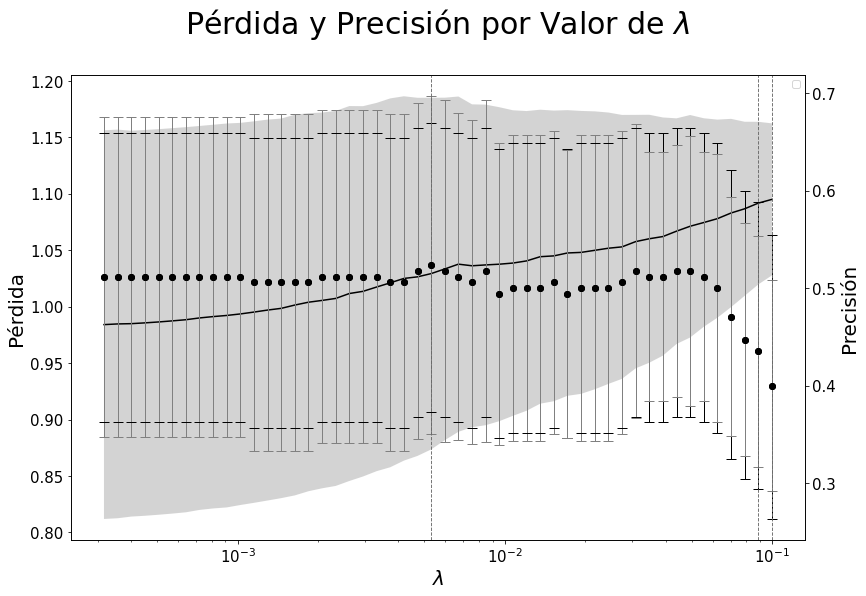

In [ ]:
# plot acc & loss
#plot
df_loss = dict_best_lambdas.get('stats').get('loss')
df_acc = dict_best_lambdas.get('stats').get('acc')
lambs = dict_best_lambdas.get('lambdas')

# plot loss
fig, ax1 = plt.subplots()

mu = df_loss['mean_loss']
sigma = df_loss['std_loss']
ax1.plot(lambdas, mu, color='black')
ax1.fill_between(lambdas, mu + sigma, mu - sigma, facecolor='darkgrey', alpha=0.5)

ax1.set_xscale('log')
ax1.set_ylabel('Pérdida', fontsize=20)
ax1.set_xlabel('$\lambda$', fontsize=20)
ax1.tick_params(axis='y', labelsize=15)
ax1.tick_params(axis='x', labelsize=15)
ax1.legend()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# plt accuracy
theta = df_acc["mean_acc"]

# willson confidence intervals of blli trails
# substract 'theta' because the plot -/+ the theta value for upper/lower CI
thetaCI_l = theta - df_acc['ci_lower'] 
thetaCI_u = df_acc['ci_upper'] - theta

thetaCI = np.vstack((thetaCI_l, thetaCI_u))

ax2.errorbar(
    lambdas,
    theta,
    yerr=thetaCI,
    capsize=5,
    elinewidth=1,
    color ='black',
    ecolor='black',
    fmt='o'
)

# 1 std intervals (as Hastie & Tibshirani)
thetaCI_l = df_acc['std_acc'] 
thetaCI_u = df_acc['std_acc'] 
thetaCI = np.vstack((thetaCI_l, thetaCI_u))

ax2.errorbar(
    lambdas,
    theta,
    yerr=thetaCI,
    capsize=5,
    elinewidth=1,
    color ='black',
    ecolor='gray',
    fmt='o'
)


ax2.set_xscale('log')
ax2.set_ylabel('Precisión', fontsize=20)
ax2.tick_params(axis='y', labelsize=15)
ax2.tick_params(axis='x', labelsize=15)

# merge plots
fig.tight_layout(rect=[0, 0.03, 1*2, 0.95*2])

# add lambdas
plt.axvline(x=lambs['optimal'], color='dimgray', linestyle='--', linewidth = 0.9)
plt.axvline(x=lambs['sparser_1std'], color='dimgray', linestyle='--', linewidth = 0.9)
plt.axvline(x=lambs['sparser_ci'], color='dimgray', linestyle='--', linewidth = 0.9)

# add title 
plt.title("Pérdida y Precisión por Valor de $\lambda$\n", fontsize=30)


# save plot #
# generate figure folder
if not os.path.exists("Figures_Colab"):
  os.makedirs("Figures_Colab")

# generate lasso folder
if not os.path.exists("Figures_Colab/Lasso_Selection"):
  os.makedirs("Figures_Colab/Lasso_Selection")

# save figure
plt.savefig("Figures_Colab/Lasso_Selection/TCV_acc_both.png", bbox_inches='tight')

# show figure #
plt.show()

## Look all the weights $W$ per value of $\lambda$

In [ ]:
#@title Texto de título predeterminado
# get all the W weights per penalization value for ALL the train and validation test
dict_weights_decayment = nn_utils_ravj.get_lassoWeights(
    dbb=dbb,
    lambdas=lambdas,
    metric='loss',
    seed=SEED_VALUE
)


progress: |██████████| 100.0% complete


Plot how weights decay per $Y_{i}$ objective

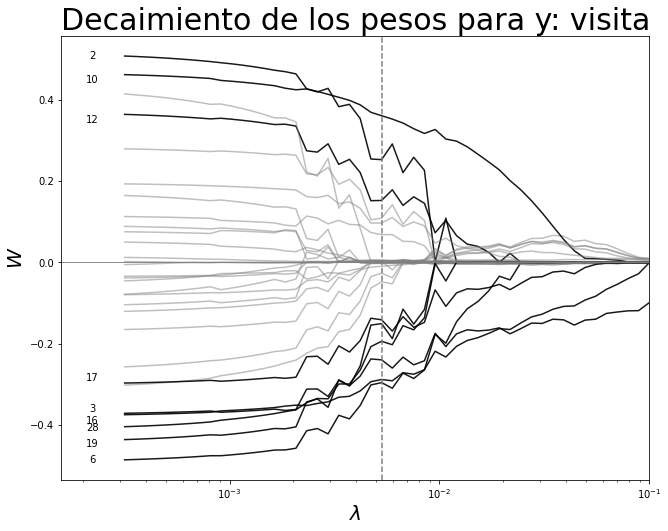

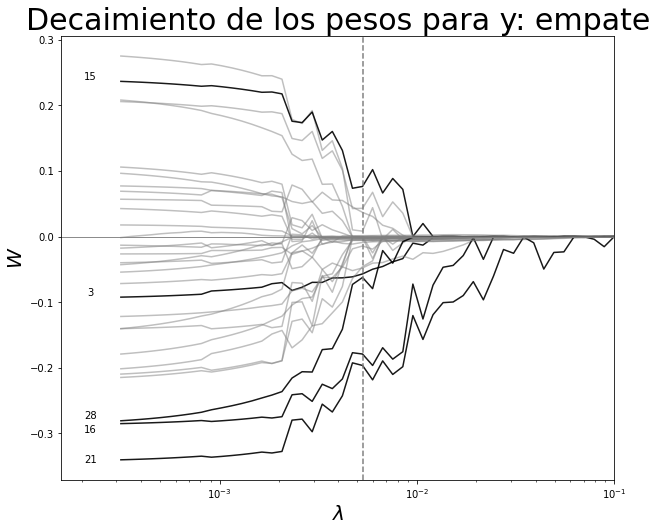

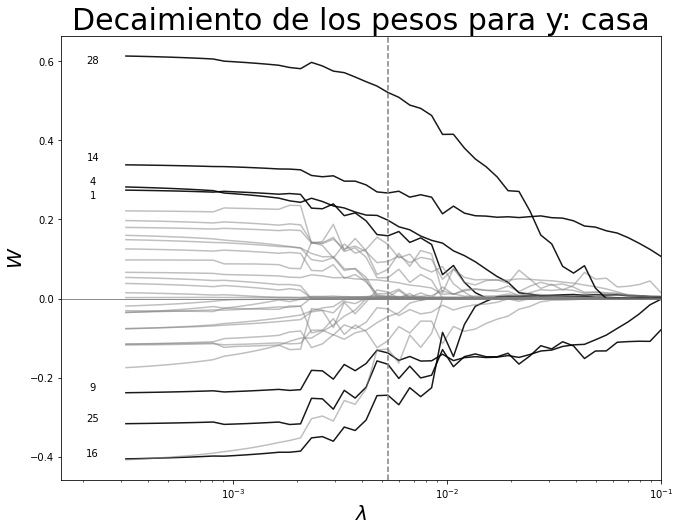

In [ ]:
# init params
NAMES_Y = ('visita', 'empate', 'casa')
THRESHOLD = 1
lambda_model = dict_best_lambdas.get('lambdas').get('optimal')

# get cube of the weights of the output (unique) layer
W_lambda_list = [
v for theta in list(dict_weights_decayment.get('dic_thetas').values())
    for k,v in theta.items() if k == 'W'
]
W_lambda3D = np.stack(W_lambda_list, axis=2)

n_covars, n_y, n_lambdas = W_lambda3D.shape



# plot each covariable by type of objective var
for i in range(n_y):
  W_yi =  W_lambda3D[:, i, :].transpose()

  # plot weight decayment
  fig = plt.figure()
  ax = fig.add_subplot(111)
  texts = []
  # append number of the covariable
  ilambda = np.argmax(lambdas >= lambda_model)
  Wi_std = np.std(W_yi[ilambda])
  threshold = THRESHOLD * Wi_std

  for j in range(n_covars):
      # if it is an "important" variable
      if np.abs(W_yi[ilambda, j]) >= threshold:
          ax.plot(lambdas, W_yi[:, j], color = 'black', alpha=0.9)
          texts.append(plt.text(0.7*lambdas[0], W_yi[0, j], s=str(j+1), fontsize=10))
      else:
          ax.plot(lambdas, W_yi[:, j], color = 'gray', alpha=0.5)

  adjust_text(
      texts, 
      only_move={'points':'y', 'text':'y'}, 
      autoalign='y', 
      force_points=0
  )

  # show lambda of the model
  plt.axvline(x=lambda_model, linestyle='--', color='gray')

  # show 0 threshold
  plt.axhline(y=0, linewidth=0.9, color='gray')

  ax.set_xscale('log')
  plt.xlim(0.5*lambdas[0], 1e-1)
  plt.ylabel('$W$', fontsize=20)
  plt.xlabel('$\lambda$', fontsize=20)
  plt.title('Decaimiento de los pesos para y: ' + NAMES_Y[i], fontsize=30)
  
  # reescale plot
  fig.tight_layout(rect=[0, 0.03, 1*2, 0.95*2])

  # save plot #
  # generate figure folder
  if not os.path.exists("Figures_Colab"):
    os.makedirs("Figures_Colab")

  # generate lasso folder
  if not os.path.exists("Figures_Colab/Lasso_Selection"):
    os.makedirs("Figures_Colab/Lasso_Selection")

  folder_graphs = "Figures_Colab/Lasso_Selection/By_Objective"
  if not os.path.exists(folder_graphs):
    os.makedirs(folder_graphs)

  # save figure
  filename = folder_graphs + "/" + NAMES_Y[i] + "_weights_decay.png"

  plt.savefig(filename, bbox_inches='tight')

  # show plot
  plt.show()


Plot weights decayment per covariable $X_{i}$


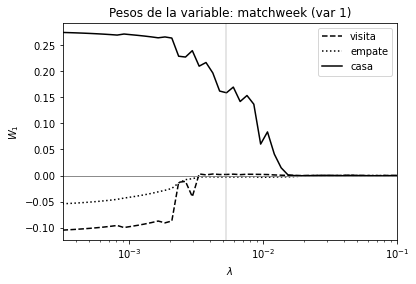

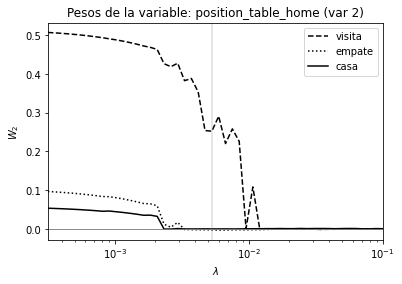

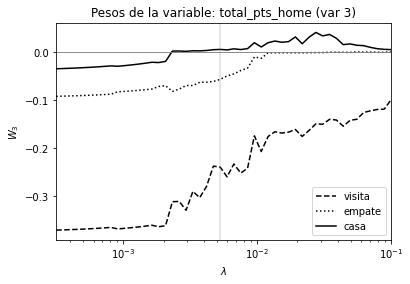

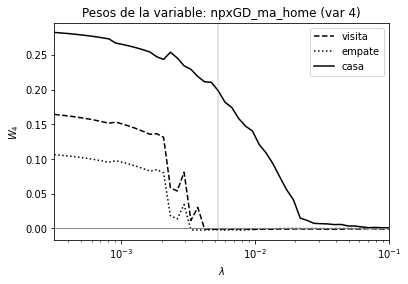

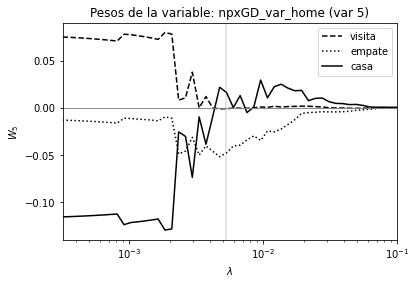

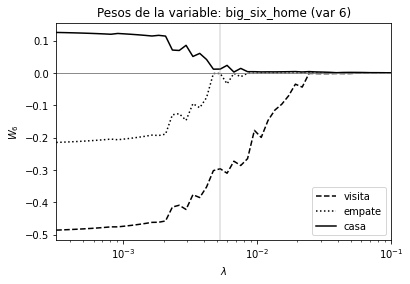

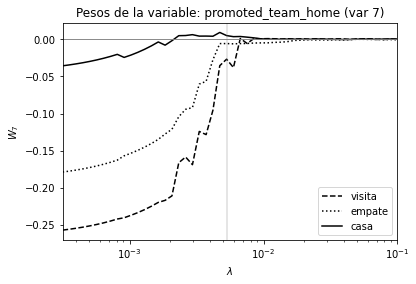

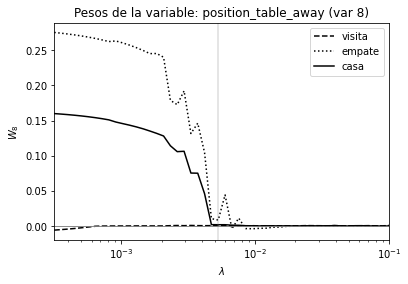

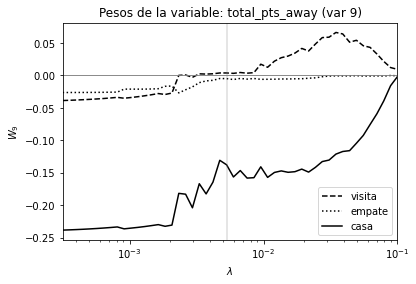

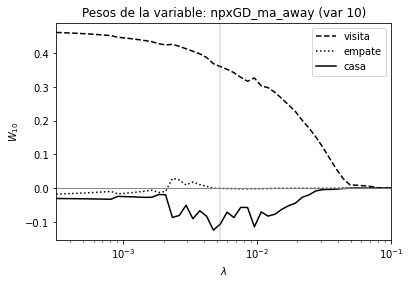

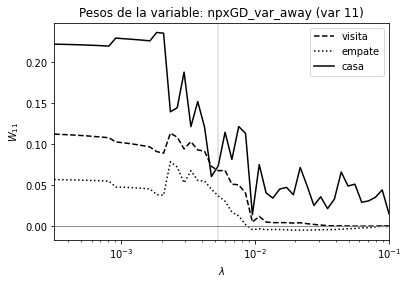

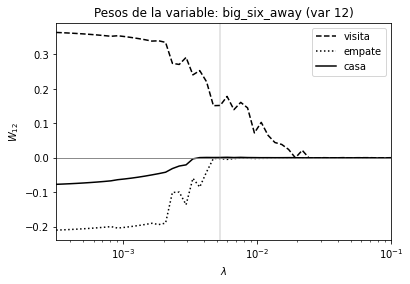

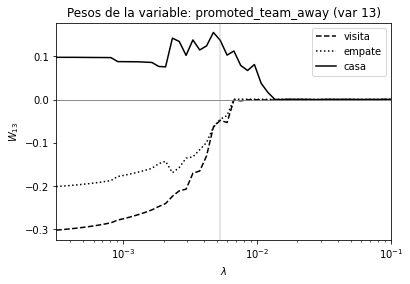

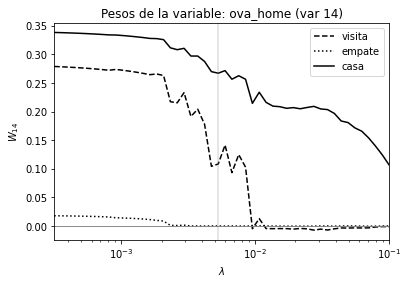

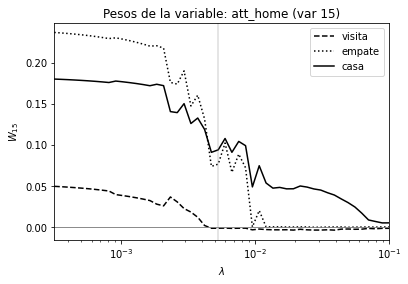

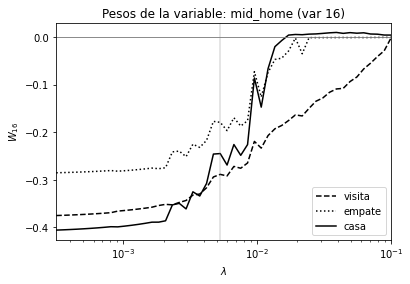

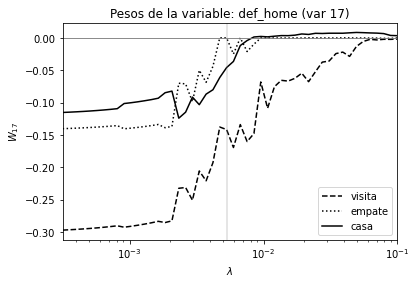

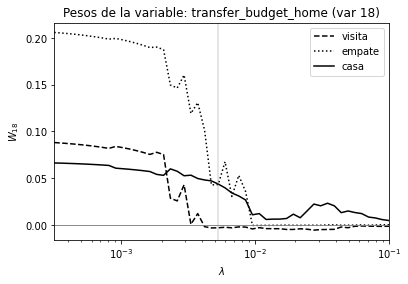

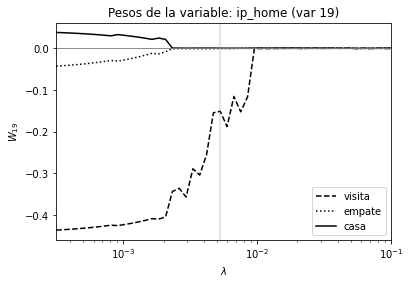

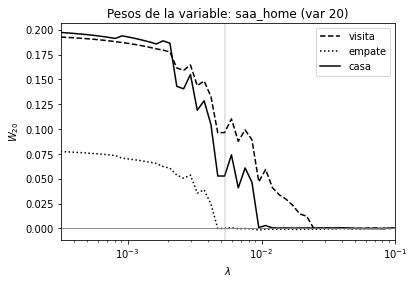

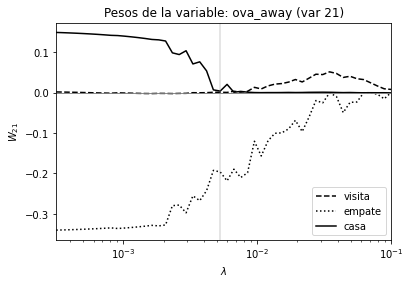

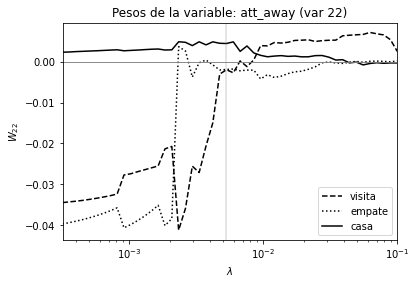

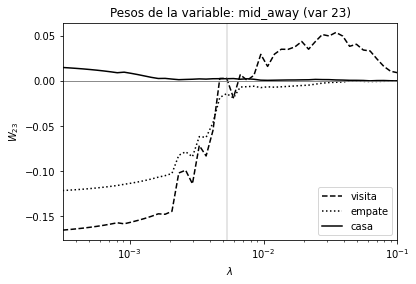

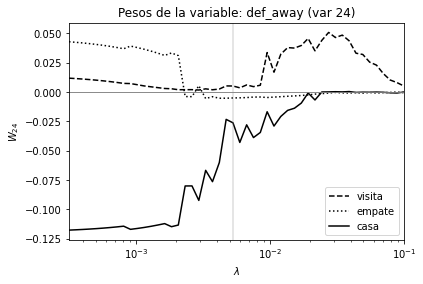

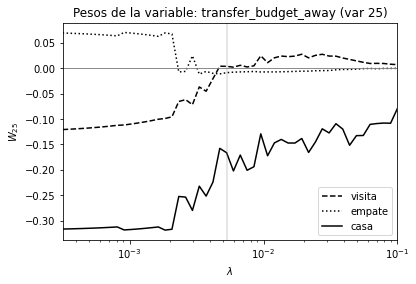

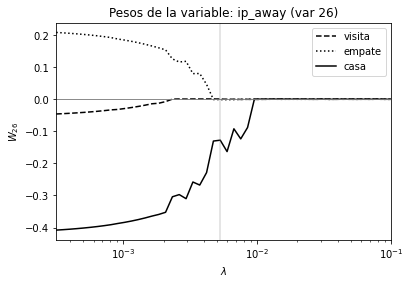

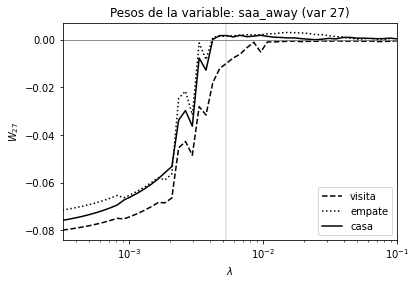

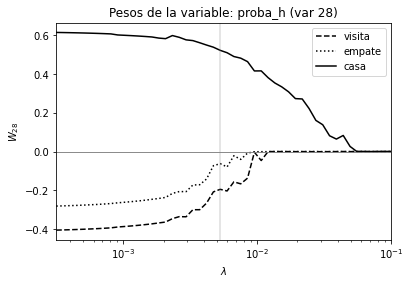

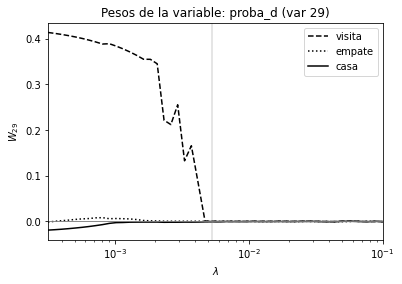

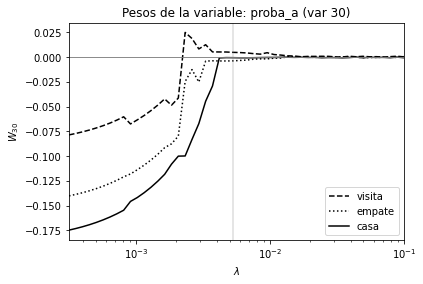

In [ ]:
# format in plots
LINESTYLES = ['--', ':', '-']
NAMES_Y = ('visita', 'empate', 'casa')

# plot each covariable weight for all y classes
for j in range(n_covars):
    W_x = W_lambda3D[j]

    fig = plt.figure()
    ax = fig.add_subplot(111)

    # plot each layer
    for i in range(n_y): # 3 y's (classes): away, draw, home
      ax.plot(lambdas, W_x[i], label=NAMES_Y[i], color = 'black', linestyle=LINESTYLES[i])

    # show lambda of the model
    plt.axvline(x=lambda_model, linewidth=0.4, color='gray')

    # show 0 threshold
    plt.axhline(y=0, linewidth=0.9, color='gray')

    ax.set_xscale('log')
    ax.legend()
    plt.xlim(lambdas[0], 1e-1)
    plt.ylabel('$W_{{%s}}$' % str(j+1))
    plt.xlabel('$\lambda$')
    plt.title('Pesos de la variable: ' + vars_model[j] + ' (var '+ str(j+1) + ')')

    # save plot #
    # generate figure folder
    if not os.path.exists("Figures_Colab"):
      os.makedirs("Figures_Colab")

    # generate lasso folder
    if not os.path.exists("Figures_Colab/Lasso_Selection"):
      os.makedirs("Figures_Colab/Lasso_Selection")

    folder_graphs = "Figures_Colab/Lasso_Selection/By_Covars"
    if not os.path.exists(folder_graphs):
      os.makedirs(folder_graphs)

    # save figure
    filename = folder_graphs + "/" + vars_model[j] + "_decay.png"

    plt.savefig(filename, bbox_inches='tight')


    plt.show()


# Make a cache of all

Look this [link](!https://stackoverflow.com/questions/60253296/how-do-i-cache-python-variables-in-google-colab) to see how to do it. This is for future loggins, so the user doesn't have to re-run all the script to get the values of the variables.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/cache_tesis/cache_nn_vars_selection'

!pip install cache-magic
import cache_magic
!mkdir .cache
!ln -s '/content/drive/MyDrive/cache_tesis/cache_nn_vars_selection' /content/.cache

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/cache_tesis/cache_nn_vars_selection
ln: failed to create symbolic link '/content/.cache': File exists


# Results

We need to run the __cache__ cell in order to access our own google drive and save the plots in our personal drive.

In [ ]:
# copy Figures_Colab and ALL the files in it to our google drive
%cp -R Figures_Colab/ /content/drive/MyDrive/

We observed the following:

1. The best **penalization** using the 'loss' (cross entropy) metric but regarding the accuracy of the model were the following:
  - 'optimal': 0.005302611335911987
  - 'sparser_1std': 0.08891593339164641
  - 'sparser_ci': 0.1

  We used the `optimal` $\lambda_{*}$ instead of the `sparser_1std` or `sparser_ci` $\lambda$ by the fact that, althought that the best accuracy obtained $\lambda_{*}$ the 1 std/confidence interval $\lambda$ also contained that best accuracy, the accuracy drop down more than a 100 base points for both cases.

  Also, the loss _very few times_ went down at increasing $\lambda$ in the TCV, so for the later model, we should use low values of penalization, either for lasso, ridge or elastic net.


---

2. **Power predictor variables**.
  - For _Home_:
    The variables with predictive power were:
    - 1, 4, 9, 14, 16, 25, 28; `matchweek`, `npxGD_ma_home`, `total_pts_away` (negative), `ova_home`, `mid_home` (negative), `transfer_budget_away` (negative), `proba_home`)

  - For _Draw_: 
    The variables with predictive power were:
    - 3, 15, 16, 21, 28; `total_pts_home` (negative), `att_home`, `mid_home` (negative), `ova_away` (negative), `proba_h` (negative)

  - For _Away_: 
    The variables with predictive power were:
    - 2, 3, 6, 10, 12, 16, 17, 19, 28; `position_table_home`, `total_pts_home` (negative), `big_six_home` (negative), `npxGD_ma_away`, `big_six_away`, `mid_home` (negative), `def_home` (negative), `ip_home` (negative), `proba_h` (negative)


3. **Behaviour of variables along penalization**
Look `Figures_Colab/Lasso_Selection/By_Covars` to see each plot




## Selection of variables:

### IN
- (1) matchweek: it look that (for _Home_), the matchweek is a good predictor
- (3) total_pts_home
- (9) total_pts_away 
- (4) npxGD_ma_home
- (10) npxGD_ma_away
- (5) npxGD_var_home !
- (11) npxGD_var_away !
- (6) big_six_home
- (12) big_six_away
- (13) promoted_team_away
- (15) att_home
- (17) def_home
- (22) att_away
- (24) def_away
- (18)
- (19)
- (26)
- (25)
- (28)
- (30)




### OUT
- (2) position_table_home: is very correleated with total_pts_home. It may induce collinearity
- (8) position_table_away: is very correleated with total_pts_away. It may induce collinearity
- (7) promoted_team_home
- (14)
- (21)
- (16)
- (23)

